In [93]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp

In [94]:
print("PyTorch版本:", torch.__version__)
print("CUDA:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA版本:", torch.version.cuda)
    print("GPU數量:", torch.cuda.device_count())
    print("當前GPU名稱:", torch.cuda.get_device_name(0))
    print("當前GPU記憶體:")
    print(f"  - 總記憶體: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"  - 已分配記憶體: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  - 已緩存記憶體: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("GPU不可用，將使用CPU進行計算")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用設備: {device}")

test_tensor = torch.randn(3, 3).to(device)
print(f"測試tensor設備: {test_tensor.device}")
print(f"測試tensor:\n{test_tensor}")

PyTorch版本: 2.4.0a0+f70bd71a48.nv24.06
CUDA: True
CUDA版本: 12.5
GPU數量: 1
當前GPU名稱: NVIDIA GeForce RTX 4070
當前GPU記憶體:
  - 總記憶體: 11.99 GB
  - 已分配記憶體: 0.12 GB
  - 已緩存記憶體: 0.25 GB
使用設備: cuda
測試tensor設備: cuda:0
測試tensor:
tensor([[-0.2174, -0.1267, -1.0359],
        [-1.6658,  0.1632,  1.1588],
        [ 0.1317, -0.1904, -0.6663]], device='cuda:0')


In [95]:
# Gyro
# Radius
R = 1
# Height
H = 0.5
# Mass
M = 0.5
# Moment of inertia
I_1 = 0.25 * M * R **2 + M * H**2
I_2 = 0.25 * M * R **2 + M * H**2
I_3 = 0.5 * M * R **2

# Gravity
g = 9.8

# Initial conditions
THETA_0 = 0.5 * np.pi
PHI_0 = np.pi
PSI_0 = 0

D_THETA_0 = 0
D_PHI_0 = -1
D_PSI_0 = 6

# Time
TOTAL_TIME = 2

#Training parameters
EPOCHS = 6000
BATCH_SIZE = 128
LEARNING_RATE = 0.0001


In [96]:
def lagrangian(x, d_x, I, M, g, H):
    kinetic_energy = 0.5 * I[0] * (d_x[:,2] ** 2 * torch.sin(x[:,1]) ** 2 + d_x[:,1] ** 2) + 0.5 * I[2] * (d_x[:,2] * torch.cos(x[:,1]) + d_x[:,2]) ** 2
    potential_energy = M * g * H * torch.cos(x[:,1])
    return kinetic_energy - potential_energy

def lagrangian_equation(x, d_x, t, I, M, g, H):
    L = lagrangian(x, d_x, I, M, g, H).reshape(-1, 1)
    d_L_d_x = torch.autograd.grad(L, x, grad_outputs=torch.ones_like(L), create_graph=True)[0]
    d_L_dd_x = torch.autograd.grad(L, d_x, grad_outputs=torch.ones_like(L), create_graph=True)[0]
    d_L_dd_x_d_t = torch.autograd.grad(
    outputs=d_L_dd_x,
    inputs=t,
    grad_outputs=torch.ones_like(d_L_dd_x),
    create_graph=True,
    allow_unused=True
    )[0]
    return d_L_dd_x_d_t - d_L_d_x

def angular_momentum(d_x, I):
    return I[0] * d_x[0] ** 2 + I[1] * d_x[1] ** 2 + I[2] * d_x[2] ** 2

def eularian_transform(x, d_x):

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    omega_1 = phi_dot * torch.sin(theta) * torch.sin(psi) + theta_dot * torch.cos(psi)
    omega_2 = phi_dot * torch.sin(theta) * torch.cos(psi) - theta_dot * torch.sin(psi)
    omega_3 = phi_dot * torch.cos(theta) + psi_dot

    return torch.stack((omega_1, omega_2, omega_3), dim=1)

def moment_of_force(x, d_x, I, M, g, H):
    I_12 = I[0]
    I_3 = I[2]

    theta_dot = d_x[:,0]
    phi_dot = d_x[:,1]
    psi_dot = d_x[:,2]

    theta = x[:,0]
    phi = x[:,1]
    psi = x[:,2]

    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)
    
    epsilon = 1e-10
    condition = torch.abs(sin_theta) < epsilon
    signed_epsilon = torch.copysign(torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), sin_theta)
    signed_epsilon = torch.where(sin_theta == 0, torch.tensor(epsilon, device=sin_theta.device, dtype=sin_theta.dtype), signed_epsilon)
    safe_sin_theta = torch.where(condition, signed_epsilon, sin_theta)

    s_omega_30 = phi_dot * cos_theta + psi_dot

    angular_acceleration_theta = phi_dot**2 * sin_theta * cos_theta - (I_3 / I_12) * phi_dot * sin_theta * s_omega_30 + (M * g * H / I_12) * sin_theta
    angular_acceleration_phi = (theta_dot / (I_12 * safe_sin_theta)) * (I_3 * s_omega_30 - 2 * I_12 * phi_dot * cos_theta)
    angular_acceleration_psi = phi_dot * theta_dot * sin_theta - angular_acceleration_phi * cos_theta


    return torch.stack((angular_acceleration_theta, angular_acceleration_phi, angular_acceleration_psi), dim=1)

In [97]:
def real_word_simulation(time, I, X_0, D_X_0):

  s_I_12 = I[0]
  s_I_3 = I[2]

  s_output = []

  s_theta = X_0[0]
  s_phi = X_0[1]
  s_psi = X_0[2]

  s_theta_dot = D_X_0[0]
  s_phi_dot = D_X_0[1]
  s_psi_dot = D_X_0[2]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot
  
  if abs(s_sin_theta) < 1e-10:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = 0
    s_psi_dot_dot = 0
  else:
    s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
    s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
    s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_output.append([s_theta, s_phi, s_psi, s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  d_t = time[1] - time[0]

  time = time[:-1]

  for _ in time:

    s_theta = s_output[-1][0]
    s_phi = s_output[-1][1]
    s_psi = s_output[-1][2]

    s_theta_dot = s_output[-1][3]
    s_phi_dot = s_output[-1][4]
    s_psi_dot = s_output[-1][5]

    s_sin_theta = np.sin(s_theta)
    s_cos_theta = np.cos(s_theta)

    if abs(s_sin_theta) < 1e-5:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = 0
      s_psi_dot_dot = 0

    else:
      s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
      s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
      s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

    s_output.append([s_theta + s_theta_dot * d_t, s_phi + s_phi_dot * d_t, s_psi + s_psi_dot * d_t, s_theta_dot + s_theta_dot_dot * d_t, s_phi_dot + s_phi_dot_dot * d_t, s_psi_dot + s_psi_dot_dot * d_t, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot])

  return np.array(s_output)

def real_word_simulation_solve_ivp_fun(time, y, I, M, g, H):
  s_I_12 = I[0]
  s_I_3 = I[2]

  s_theta = y[0]
  s_phi = y[1]
  s_psi = y[2]

  s_theta_dot = y[3]
  s_phi_dot = y[4]
  s_psi_dot = y[5]

  s_sin_theta = np.sin(s_theta)
  s_cos_theta = np.cos(s_theta)

  
  epsilon = 1e-10
  if abs(s_sin_theta) < epsilon:
    s_safe_sin_theta = np.sign(s_sin_theta) * epsilon + (1 - np.sign(s_sin_theta) ** 2) * epsilon
    if abs(s_safe_sin_theta) < epsilon:
      s_safe_sin_theta = epsilon
  else:
    s_safe_sin_theta = s_sin_theta

  s_omega_30 = s_phi_dot * s_cos_theta + s_psi_dot

  s_theta_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_sin_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_sin_theta + M * g * H * s_sin_theta) / s_I_12
  s_phi_dot_dot = (-s_I_12 * s_phi_dot * s_theta_dot * s_cos_theta + s_I_12 * s_theta_dot * s_psi_dot - (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot) / s_I_12 * s_sin_theta
  s_psi_dot_dot = (s_I_12 * s_phi_dot * s_theta_dot - s_I_12 * s_phi_dot * s_psi_dot * s_cos_theta + (s_I_12 - s_I_3) * s_omega_30 * s_theta_dot * s_cos_theta) / s_I_12 * s_sin_theta

  s_theta_dot_dot = s_phi_dot**2 * s_sin_theta * s_cos_theta - (s_I_3 / s_I_12) * s_phi_dot * s_sin_theta * s_omega_30 + (M * g * H / s_I_12) * s_sin_theta
  s_phi_dot_dot = (s_theta_dot / (s_I_12 * s_safe_sin_theta)) * (s_I_3 * s_omega_30 - 2 * s_I_12 * s_phi_dot * s_cos_theta)
  s_psi_dot_dot = s_phi_dot * s_theta_dot * s_sin_theta - s_phi_dot_dot * s_cos_theta

  return [s_theta_dot, s_phi_dot, s_psi_dot, s_theta_dot_dot, s_phi_dot_dot, s_psi_dot_dot]

def real_word_simulation_solve_ivp(time, I, X_0, D_X_0, M, g, H):
  y = [X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]]
  y_0 = np.array([X_0[0], X_0[1], X_0[2], D_X_0[0], D_X_0[1], D_X_0[2]])
  s_output = solve_ivp(real_word_simulation_solve_ivp_fun, [time[0], time[-1]], y_0, t_eval=time, args=(I, M, g, H), method='LSODA', rtol=1e-6, atol=1e-6)
  print(s_output.message)
  return np.array(s_output.y).T

In [98]:
class Model(nn.Module):  
    def __init__(self, x_0, d_x_0):
        super(Model, self).__init__()
        self.x_0 = x_0
        # self.d_x_0 = nn.Parameter(d_x_0)\
        self.d_x_0 = d_x_0
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 128),
            nn.Tanh(),
            nn.Linear(128, 3)
        )

    def forward(self, t):
        net_output = self.net(t)
        # This formulation forces the model to satisfy the initial conditions
        # y(t) = y_0 + t * y'_0 + t^2 * NN(t)
        output = self.x_0 + t * self.d_x_0 + t**2 * net_output
        return output

In [99]:
print("=== 訓練開始 ===")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

X_0 = torch.tensor([THETA_0, PHI_0, PSI_0], dtype=torch.float32).to(DEVICE)
D_X_0 = torch.tensor([D_THETA_0, D_PHI_0, D_PSI_0], dtype=torch.float32).to(DEVICE)
I = torch.tensor([I_1, I_2, I_3], dtype=torch.float32).to(DEVICE)

model = Model(X_0, D_X_0).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=200, verbose=True)

loss_data = []

def loss_function(output, time):
    # 計算一階導數 (速度)
    output_gradient_theta = torch.autograd.grad(
        outputs=output[:,0],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,0]),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_phi = torch.autograd.grad(
        outputs=output[:,1],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,1]),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_psi = torch.autograd.grad(
        outputs=output[:,2],
        inputs=time,
        grad_outputs=torch.ones_like(output[:,2]),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # 組合速度向量
    output_gradient = torch.cat([output_gradient_theta, output_gradient_phi, output_gradient_psi], dim=1)

    # 計算二階導數 (加速度)
    output_gradient_2_theta = torch.autograd.grad(
        outputs=output_gradient_theta,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_theta),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_2_phi = torch.autograd.grad(
        outputs=output_gradient_phi,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_phi),
        create_graph=True,
        retain_graph=True
    )[0]
    
    output_gradient_2_psi = torch.autograd.grad(
        outputs=output_gradient_psi,
        inputs=time,
        grad_outputs=torch.ones_like(output_gradient_psi),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # 組合加速度向量
    output_gradient_2 = torch.cat([output_gradient_2_theta, output_gradient_2_phi, output_gradient_2_psi], dim=1)
    
    # 物理方程損失
    predicted_acceleration = moment_of_force(output, output_gradient, I, M, g, H)
    physics_loss = nn.MSELoss()(predicted_acceleration, output_gradient_2)
    
    # 總損失現在只有物理損失
    total_loss = physics_loss
    
    # 為了日誌紀錄，我們仍然可以計算初始條件的 "誤差" (理論上應為0)
    initial_position_loss = nn.MSELoss()(output[0], X_0)
    initial_velocity_loss = nn.MSELoss()(output_gradient[0], D_X_0)
    initial_condition_loss = initial_position_loss + initial_velocity_loss
    
    return total_loss, initial_condition_loss, physics_loss, initial_position_loss, initial_velocity_loss

for epoch in range(EPOCHS):
    model.train()
    
    # 創建時間點
    time = torch.linspace(0, TOTAL_TIME, BATCH_SIZE).reshape(-1, 1)
    time = time.to(DEVICE)
    time.requires_grad_(True)
    
    # 前向傳播
    output = model(time)
    
    # 計算損失
    optimizer.zero_grad()
    total_loss, initial_condition_loss, physics_loss, initial_position_loss, initial_velocity_loss = loss_function(output, time)
    
    # 反向傳播
    total_loss.backward()
    
    # 梯度裁剪防止梯度爆炸
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    scheduler.step(total_loss)
    
    loss_data.append([
        initial_condition_loss.item(), 
        physics_loss.item(),
        initial_position_loss.item(),
        initial_velocity_loss.item()
    ])
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss.item():.6f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        # print(f'  - Initial Condition (should be ~0): {initial_condition_loss.item():.10f}')
        # print(f'  - Physics: {physics_loss.item():.10f}')
        # print(f'  - Position (should be ~0): {initial_position_loss.item():.10f}')
        # print(f'  - Velocity (should be ~0): {initial_velocity_loss.item():.10f}')

print("訓練完成!")

=== 訓練開始 ===
Epoch 1/6000, Loss: 93.468437, LR: 1.00e-04
Epoch 101/6000, Loss: 6.915057, LR: 1.00e-04
Epoch 201/6000, Loss: 5.922029, LR: 1.00e-04
Epoch 301/6000, Loss: 2.923143, LR: 1.00e-04
Epoch 401/6000, Loss: 1.902453, LR: 1.00e-04
Epoch 501/6000, Loss: 1.593175, LR: 1.00e-04
Epoch 601/6000, Loss: 1.453545, LR: 1.00e-04
Epoch 701/6000, Loss: 1.380277, LR: 1.00e-04
Epoch 801/6000, Loss: 1.262722, LR: 1.00e-04
Epoch 901/6000, Loss: 1.096482, LR: 1.00e-04
Epoch 1001/6000, Loss: 0.821618, LR: 1.00e-04
Epoch 1101/6000, Loss: 0.620737, LR: 1.00e-04
Epoch 1201/6000, Loss: 0.468036, LR: 1.00e-04
Epoch 1301/6000, Loss: 0.382466, LR: 1.00e-04
Epoch 1401/6000, Loss: 0.324707, LR: 1.00e-04
Epoch 1501/6000, Loss: 0.303708, LR: 1.00e-04
Epoch 1601/6000, Loss: 0.339280, LR: 1.00e-04
Epoch 1701/6000, Loss: 0.274717, LR: 1.00e-04
Epoch 1801/6000, Loss: 0.387173, LR: 1.00e-04
Epoch 1901/6000, Loss: 0.218649, LR: 1.00e-04
Epoch 2001/6000, Loss: 0.231872, LR: 1.00e-04
Epoch 2101/6000, Loss: 0.212898,

=== 結果檢查 ===
期望初始位置: [1.5707964 3.1415927 0.       ]
模型預測初始位置: [1.5707964 3.1415927 0.       ]
期望初始速度: [ 0. -1.  6.]
模型預測初始速度: [ 0. -1.  6.]

最終Total Loss: 0.028433
最終Initial Condition Loss: 0.0000000000
最終Physics Loss: 0.0284326728
最終Position Loss: 0.0000000000
最終Velocity Loss: 0.0000000000


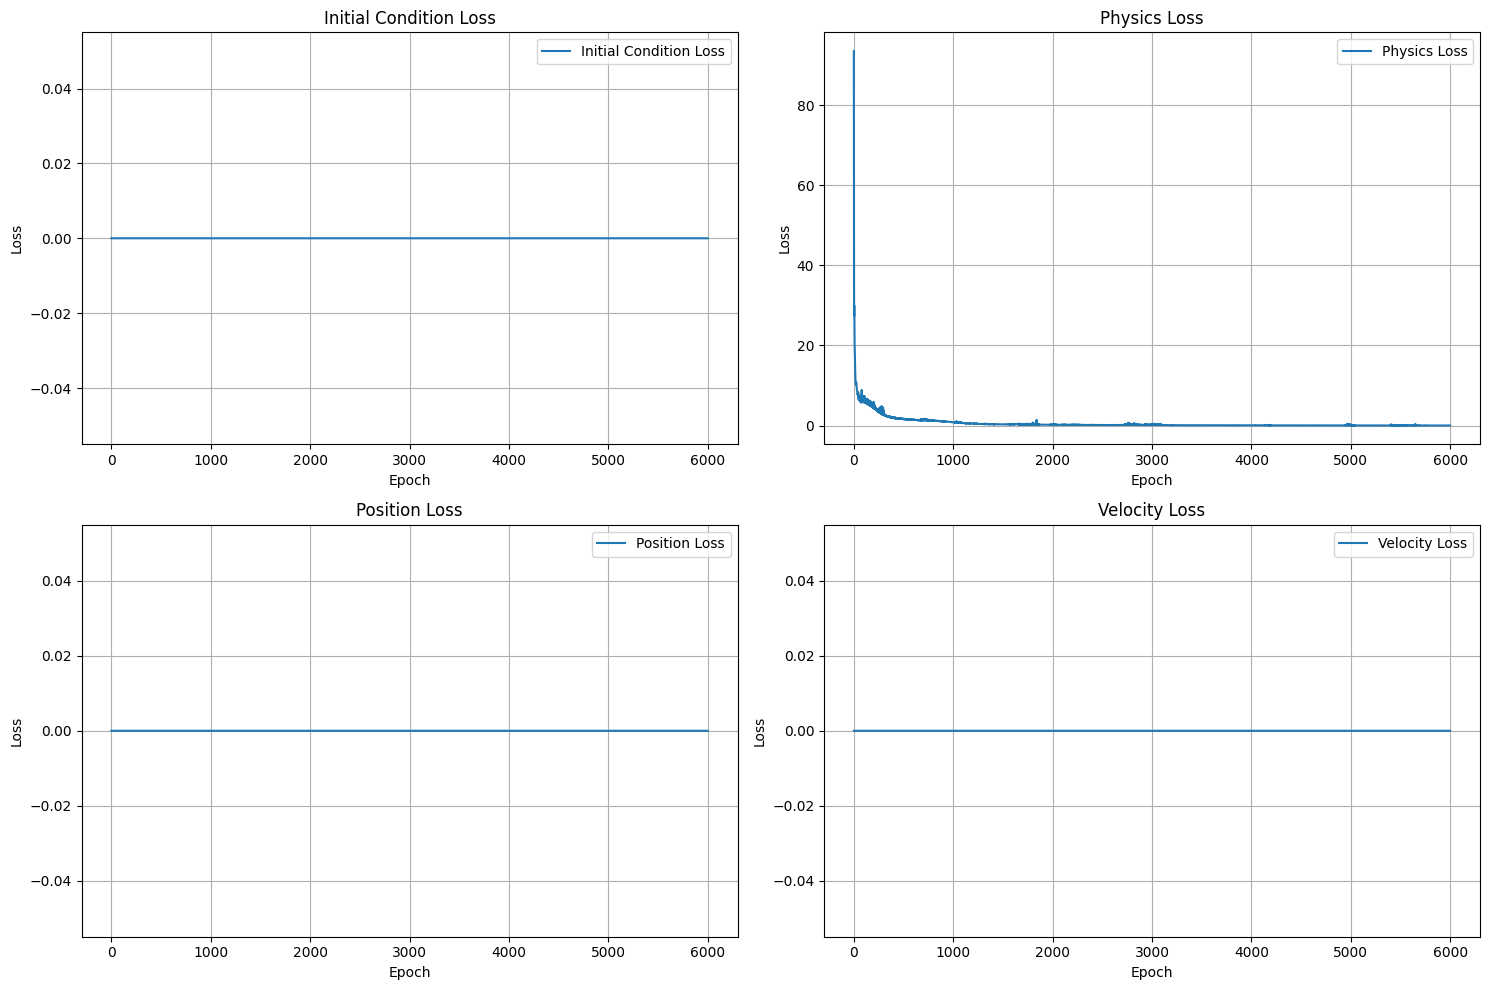

In [100]:
print("=== 結果檢查 ===")

X_0_tensor = torch.tensor([THETA_0, PHI_0, PSI_0], dtype=torch.float32).to(DEVICE)
D_X_0_tensor = torch.tensor([D_THETA_0, D_PHI_0, D_PSI_0], dtype=torch.float32).to(DEVICE)

time_test = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True).to(DEVICE)
output_test = model(time_test)

print(f"期望初始位置: {X_0_tensor.cpu().numpy()}")
print(f"模型預測初始位置: {output_test.detach().cpu().numpy().flatten()}")

output_grad_theta_val = torch.autograd.grad(output_test[0,0], time_test, create_graph=True, retain_graph=True)[0].item()
output_grad_phi_val = torch.autograd.grad(output_test[0,1], time_test, create_graph=True, retain_graph=True)[0].item()
output_grad_psi_val = torch.autograd.grad(output_test[0,2], time_test, create_graph=True)[0].item()

predicted_velocity = torch.tensor([output_grad_theta_val, output_grad_phi_val, output_grad_psi_val], device=DEVICE)

print(f"期望初始速度: {D_X_0_tensor.cpu().numpy()}")
print(f"模型預測初始速度: {predicted_velocity.detach().cpu().numpy()}")

loss_data_array = np.array(loss_data)
print(f"\n最終Total Loss: {loss_data_array[-1, 1]:.6f}") # Total loss is just physics loss
print(f"最終Initial Condition Loss: {loss_data_array[-1, 0]:.10f}")
print(f"最終Physics Loss: {loss_data_array[-1, 1]:.10f}")
print(f"最終Position Loss: {loss_data_array[-1, 2]:.10f}")
print(f"最終Velocity Loss: {loss_data_array[-1, 3]:.10f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(loss_data_array[:, 0], label='Initial Condition Loss')
plt.title('Initial Condition Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(loss_data_array[:, 1], label='Physics Loss')
plt.title('Physics Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(loss_data_array[:, 2], label='Position Loss')
plt.title('Position Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(loss_data_array[:, 3], label='Velocity Loss')
plt.title('Velocity Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The solver successfully reached the end of the integration interval.


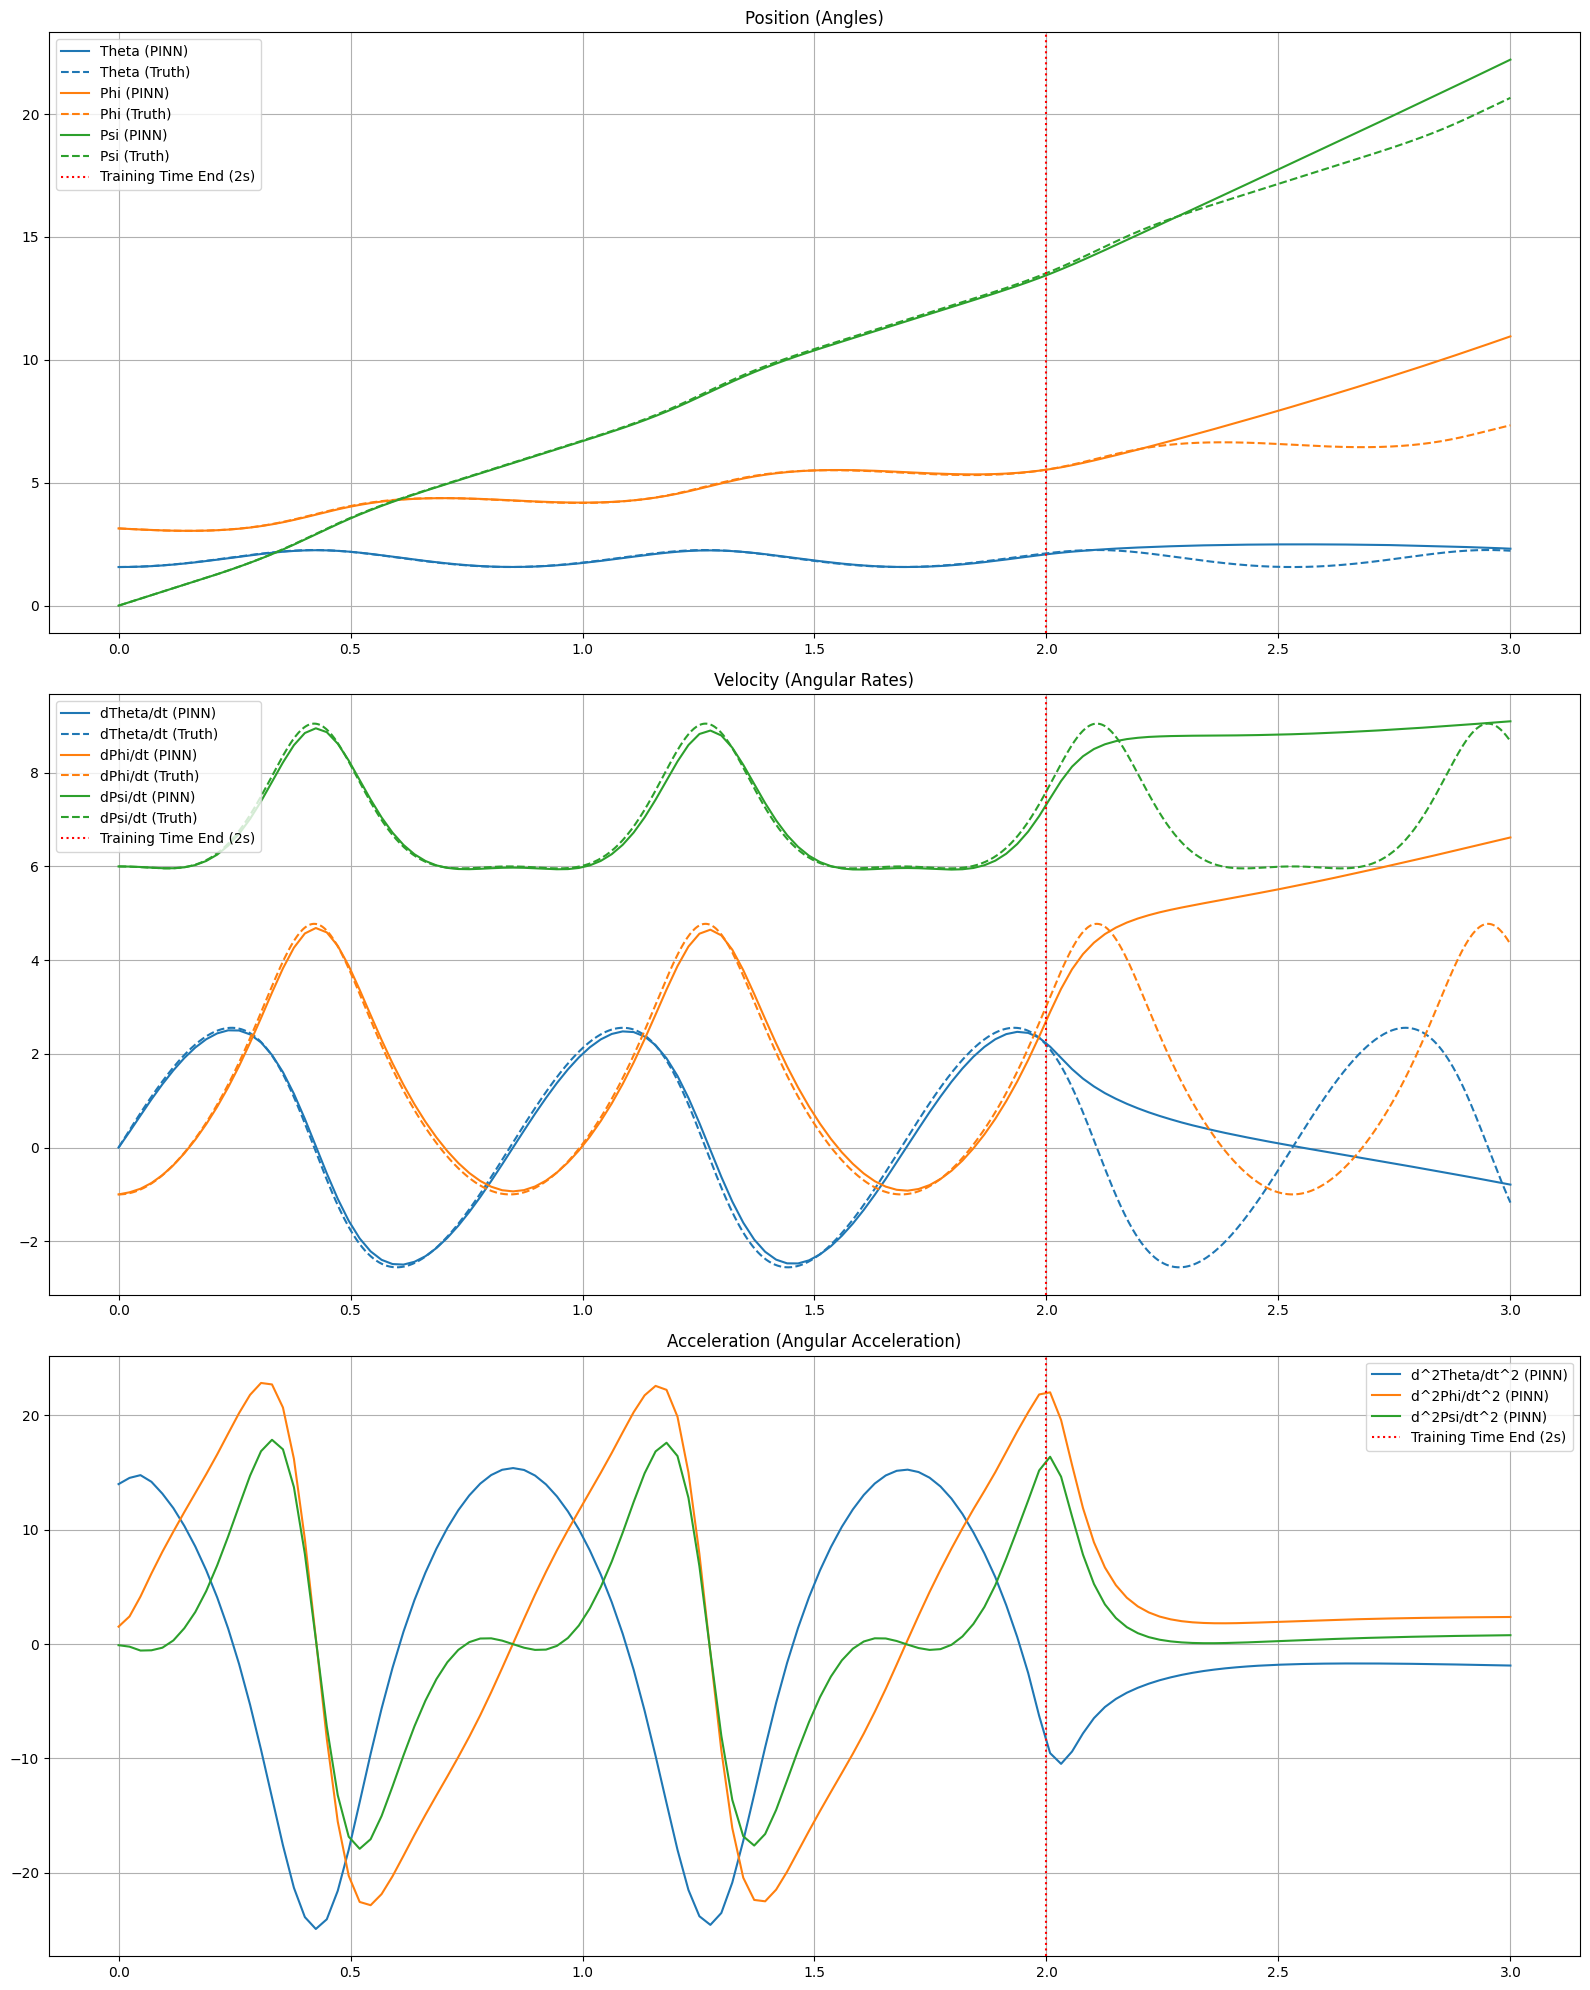

In [101]:
time = np.linspace(0, TOTAL_TIME + 1, BATCH_SIZE).reshape(-1, 1)
time = torch.tensor(time, dtype=torch.float32, requires_grad=True).to(DEVICE)

output = model(time)

output_gradient_theta = torch.autograd.grad(
    outputs=output[:,0],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,0]),
    create_graph=True
)

output_grident_2_theta = torch.autograd.grad(
    outputs=output_gradient_theta[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_theta[0]),
    create_graph=True
)

output_gradient_phi = torch.autograd.grad(
    outputs=output[:,1],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,1]),
    create_graph=True
)

output_grident_2_phi = torch.autograd.grad(
    outputs=output_gradient_phi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_phi[0]),
    create_graph=True
)

output_gradient_psi = torch.autograd.grad(
    outputs=output[:,2],
    inputs=time,
    grad_outputs=torch.ones_like(output[:,2]),
    create_graph=True
)

output_grident_2_psi = torch.autograd.grad(
    outputs=output_gradient_psi[0],
    inputs=time,
    grad_outputs=torch.ones_like(output_gradient_psi[0]),
    create_graph=True
)

output_gradient = torch.cat((output_gradient_theta[0].unsqueeze(1), output_gradient_phi[0].unsqueeze(1), output_gradient_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)
output_gradient_2 = torch.cat((output_grident_2_theta[0].unsqueeze(1), output_grident_2_phi[0].unsqueeze(1), output_grident_2_psi[0].unsqueeze(1)), dim=1).reshape(-1, 3)

output_gradient = output_gradient.detach().cpu().numpy()
output_gradient_2 = output_gradient_2.detach().cpu().numpy()

time = time.detach().cpu().numpy()
output = output.detach().cpu().numpy()

time_sim = np.linspace(0, TOTAL_TIME + 1, 1000)

X_0 = np.array([THETA_0, PHI_0, PSI_0])
D_X_0 = np.array([D_THETA_0, D_PHI_0, D_PSI_0])
I = np.array([I_1, I_2, I_3])
# output_sim = real_word_simulation(time_sim, I, X_0, D_X_0)
output_sim = real_word_simulation_solve_ivp(time_sim, I, X_0, D_X_0, M, g, H)

plt.figure(figsize=(16, 20))

# Subplot 1: Position (Angles)
plt.subplot(3, 1, 1)
plt.plot(time, output[:, 0], label='Theta (PINN)', color='C0', linestyle='-')
plt.plot(time_sim, output_sim[:, 0], label='Theta (Truth)', color='C0', linestyle='--')
plt.plot(time, output[:, 1], label='Phi (PINN)', color='C1', linestyle='-')
plt.plot(time_sim, output_sim[:, 1], label='Phi (Truth)', color='C1', linestyle='--')
plt.plot(time, output[:, 2], label='Psi (PINN)', color='C2', linestyle='-')
plt.plot(time_sim, output_sim[:, 2], label='Psi (Truth)', color='C2', linestyle='--')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Position (Angles)")

# Subplot 2: Velocity (Angular Rates)
plt.subplot(3, 1, 2)
plt.plot(time, output_gradient[:, 0], label='dTheta/dt (PINN)', color='C0', linestyle='-')
plt.plot(time_sim, output_sim[:, 3], label='dTheta/dt (Truth)', color='C0', linestyle='--')
plt.plot(time, output_gradient[:, 1], label='dPhi/dt (PINN)', color='C1', linestyle='-')
plt.plot(time_sim, output_sim[:, 4], label='dPhi/dt (Truth)', color='C1', linestyle='--')
plt.plot(time, output_gradient[:, 2], label='dPsi/dt (PINN)', color='C2', linestyle='-')
plt.plot(time_sim, output_sim[:, 5], label='dPsi/dt (Truth)', color='C2', linestyle='--')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Velocity (Angular Rates)")

# Subplot 3: Acceleration (Angular Acceleration)
# Note: solve_ivp does not directly output acceleration, so we can't plot its ground truth here.
plt.subplot(3, 1, 3)
plt.plot(time, output_gradient_2[:, 0], label='d^2Theta/dt^2 (PINN)', color='C0', linestyle='-')
plt.plot(time, output_gradient_2[:, 1], label='d^2Phi/dt^2 (PINN)', color='C1', linestyle='-')
plt.plot(time, output_gradient_2[:, 2], label='d^2Psi/dt^2 (PINN)', color='C2', linestyle='-')
plt.axvline(x=TOTAL_TIME, color='red', linestyle=':', label=f'Training Time End ({TOTAL_TIME}s)')
plt.legend()
plt.grid()
plt.title("Acceleration (Angular Acceleration)")


plt.tight_layout()
plt.show()


=== 3D 軌跡繪圖 ===


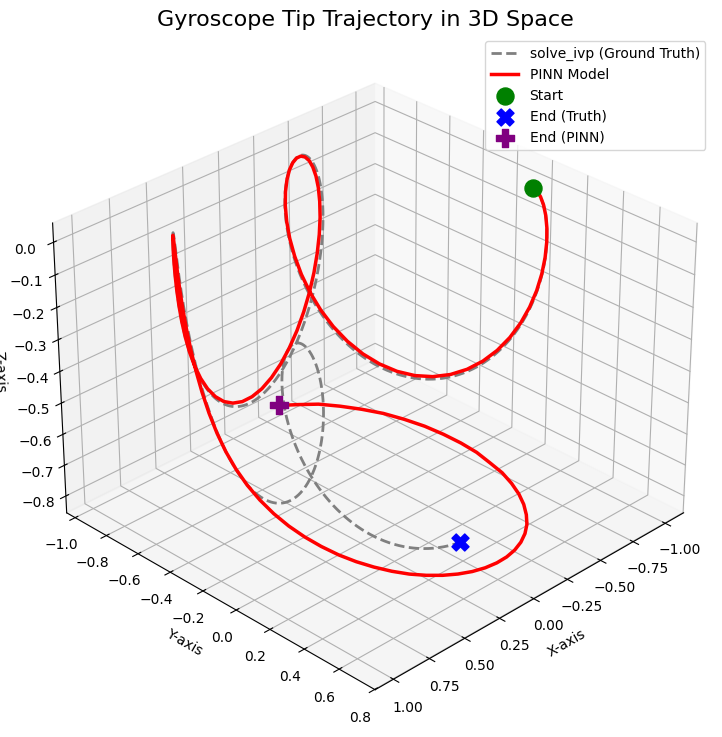

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

print("=== 3D 軌跡繪圖 ===")

if 'output' not in locals() or 'output_sim' not in locals():
    print("請先執行前面的儲存格來生成 'output' 和 'output_sim' 數據。")
else:
    L = 1.0

    theta_sim = output_sim[:, 0]
    phi_sim = output_sim[:, 1]

    x_sim = L * np.sin(theta_sim) * np.cos(phi_sim)
    y_sim = L * np.sin(theta_sim) * np.sin(phi_sim)
    z_sim = L * np.cos(theta_sim)

    theta_model = output[:, 0]
    phi_model = output[:, 1]

    phi_offset = phi_model[0] - phi_sim[0]
    phi_model_corrected = phi_model - phi_offset

    x_model = L * np.sin(theta_model) * np.cos(phi_model_corrected)
    y_model = L * np.sin(theta_model) * np.sin(phi_model_corrected)
    z_model = L * np.cos(theta_model)

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_sim, y_sim, z_sim, label='solve_ivp (Ground Truth)', color='gray', linestyle='--', linewidth=2)
    
    ax.plot(x_model, y_model, z_model, label='PINN Model', color='red', linewidth=2.5)

    ax.scatter(x_sim[0], y_sim[0], z_sim[0], color='green', s=150, label='Start', marker='o', depthshade=False)
    ax.scatter(x_sim[-1], y_sim[-1], z_sim[-1], color='blue', s=150, label='End (Truth)', marker='X', depthshade=False)
    ax.scatter(x_model[-1], y_model[-1], z_model[-1], color='purple', s=150, label='End (PINN)', marker='P', depthshade=False)

    ax.set_title("Gyroscope Tip Trajectory in 3D Space", fontsize=16)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()
    ax.grid(True)
    
    ax.view_init(elev=30., azim=45)

    plt.show()
